In [1]:
correct_cwd = False

In [2]:
import os
if correct_cwd == False:
    os.chdir("..")
    correct_cwd = True

# Create a class conditional normalizing flow

In [3]:
import nux
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit, vmap
import nux.networks as net
import nux.util as util
import optax
import tqdm
import matplotlib.pyplot as plt
from experiments.datasets import get_dataset

### NuX has a dataset utility that returns an iterator of doubly-batched inputs

In [4]:
train_ds, test_ds = get_dataset(dataset_name="swirl_clusters",
                                train_batch_size=256,
                                train_n_batches=None, # Don't return doubly batched inputs
                                test_batch_size=64,
                                test_n_batches=None,
                                classification=True,
                                label_keep_percent=1.0,
                                random_label_percent=0.0)

In [5]:
data = next(train_ds)
print(util.tree_shapes(data))

{'x': (256, 2), 'y': (256, 5), 'y_is_labeled': (256,)}


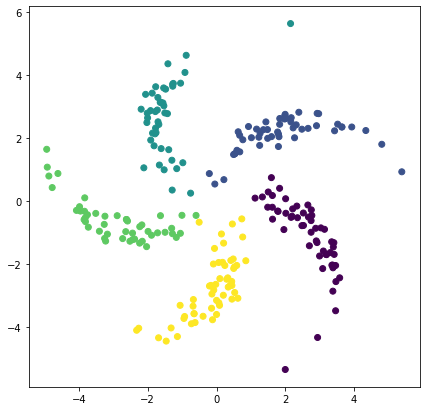

In [6]:
not_one_hot_labels = data["y"].argmax(axis=1)
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.scatter(*data["x"].T, c=not_one_hot_labels)

### The flow will use dense and logistic mixture cdf layers

In [7]:
# Specify what the neural network should look like for the coupling layers
def create_network(out_shape):
    return net.MLP(out_dim=out_shape[-1],
                   layer_sizes=[32]*2,
                   nonlinearity="relu",
                   parameter_norm=None,
                   dropout_rate=None)

# Coupling layers can take extra kwargs to specify their functionality.  In this 
# notebook, as are using use_condition=True to specify that the flow learns p(x|y)
use_condition = True             # The flow defines a conditional transform and should expect a "condition" input.
split_kind = "channel"           # "channel" or "checkerboard".  How an input should be split for coupling.
condition_method = "concat"      # "concat" or "nin".  How we should build a conditioner into the neural network.
masked = False                   # Should the network accept a masked input, or half of the input?
apply_to_both_halves = False     # Apply a non-parametrized transform to the other half of the input?
create_network = create_network  # What neural network should we use?

coupling_kwargs = dict(use_condition=use_condition,
                       split_kind=split_kind,
                       condition_method=condition_method,
                       masked=masked,
                       apply_to_both_halves=apply_to_both_halves,
                       create_network=create_network)

# Function to create the normalizing flow
def create_flow():
    return nux.sequential(nux.AffineLDU(),
                          nux.LogisticMixtureLogit(n_components=8, **coupling_kwargs),
                          nux.AffineLDU(),
                          nux.LogisticMixtureLogit(n_components=8, **coupling_kwargs),
                          nux.AffineLDU(),
                          nux.UnitGaussianPrior())

### You must pass the values to condition on using the "condition" kwarg in your inputs.
### In this example, we will be conditioning on a one-hot label

In [8]:
def parse_data(data):
    inputs = {}
    inputs["x"] = data["x"]
    inputs["condition"] = data["y"]
    return inputs

### Initialize the flow with a batch of data.  NuX performs data-dependent initialization to correctly initialize layers such as ActNorm or weights using weight normalization

In [9]:
key = random.PRNGKey(0)

# nux.transform_flow is like Haiku's hk.transform function to initialize a Module.
flow = nux.transform_flow(create_flow)

# Initialize the flow with data and specify the batch axes.
# *** there is a known issue when batch_axes is not () or (0,),
#     so for the moment only use singly batched inputs at initialization ***
# After initialization, your flow will automatically know how any input is batched!
params, state = flow.init(key, parse_data(data), batch_axes=(0,))

### Check that the flow is invertible

In [10]:
inputs = parse_data(data)

# Pass data through the flow to the latent space
outputs, state = flow.apply(params, state, key, inputs)
print(f"outputs shapes: {util.tree_shapes(outputs)}")

# Pass the latent values back through the flow to the data space.
# sample=True tells the flow to run in reverse
# reconstruction=True tells the prior to not override its inputs with samples of the same shape
reconstructions, state = flow.apply(params, state, key, outputs, sample=True, reconstruction=True)
print(f"reconstructions shapes: {util.tree_shapes(reconstructions)}")

outputs shapes: {'condition': (256, 5), 'log_det': (256,), 'log_pz': (256,), 'x': (256, 2)}
reconstructions shapes: {'condition': (256, 5), 'log_det': (256,), 'log_pz': (256,), 'x': (256, 2)}


### Create a loss function to optimize

In [11]:
def loss(params, state, key, inputs, **kwargs):
    outputs, state = flow.apply(params, state, key, inputs, **kwargs)
    
    # Compute the negative log likelihood
    log_px = outputs["log_pz"] + outputs["log_det"]
    nll = -log_px.mean()
    
    # We need to return the updated state as an auxilliary output in case
    # our network has parameters that are not updated using gradient descent
    # such as batch norm statistics.
    return nll, state

In [12]:
loss(params, state, key, inputs, is_training=True)

(DeviceArray(4.6065226, dtype=float32), FlatMapping({}))

### Use JAX to get the gradient function

In [13]:
valgrad = jax.value_and_grad(loss, has_aux=True)
valgrad = jax.jit(valgrad)

### Create the optimizer

In [14]:
import optax
opt_init, opt_update = optax.adam(learning_rate=1e-3)
opt_state = opt_init(params)
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(optax.apply_updates)

### Train the model

In [15]:
n_batches = 1000

pbar = tqdm.tqdm_notebook(list(range(n_batches)))
for i in pbar:
    # Generate the next batch of data
    key, train_key = random.split(key, 2)
    data = next(train_ds)     # Pull the next batch of data
    inputs = parse_data(data) # Convert the data to the form NuX expects
    
    # Compute the gradients
    (nll, state), g = valgrad(params, state, train_key, inputs, is_training=True)
    
    # Take a gradient step
    updates, opt_state = opt_update(g, opt_state, params)
    params = apply_updates(params, updates)
    
    pbar.set_description(f"loss: {nll:3.2f}")

/home/eddie/anaconda3/envs/flow/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


### Pull some class conditional samples from the model

In [16]:
n_classes = 5
n_samples_per_class = 1000
y = jnp.repeat(jnp.arange(n_classes), n_samples_per_class)
y_one_hot = y[:,None] == jnp.arange(n_classes)

# The prior will override this value.
x_template = jnp.zeros((y_one_hot.shape[0], 2))

inputs = {"x": x_template, "condition": y_one_hot}
samples, _ = flow.apply(params, state, key, inputs, sample=True)
print(util.tree_shapes(samples))

{'condition': (5000, 5), 'log_det': (5000,), 'log_pz': (5000,), 'x': (5000, 2)}


### Plot the samples

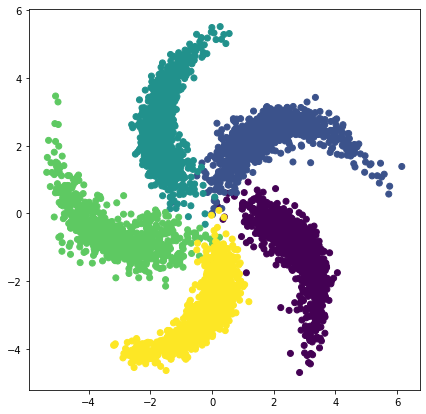

In [22]:
plot_size = 7
fig, ax = plt.subplots(1, 1, figsize=(plot_size, plot_size))
ax.scatter(*samples["x"].T, c=y)